In [23]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

df = pd.read_csv('AOVData.csv')

In [24]:
df.shape

(510, 4)

In [25]:
df.head(10)

,Car_ID,manufacturer,fuel_type,co_emissions
0,1,Audi,Petrol,441.55
1,2,BMW,E85,376.47
2,3,BMW,E85,414.12
3,4,BMW,E85,351.41
4,5,Volvo,E85,284.59
5,6,Audi,E85,200.18
6,7,Ford,LPG,479.92
7,8,Audi,LPG,315.45
8,9,Audi,E85,347.61
9,10,Volvo,E85,412.86


In [26]:
df['co_emissions'].describe()

count    510.000000
mean     358.456882
std       66.912999
min      162.070000
25%      312.630000
50%      356.190000
75%      410.645000
max      544.560000
Name: co_emissions, dtype: float64

(array([ 1.,  2.,  4., 12., 14., 26., 37., 57., 53., 64., 57., 39., 48.,
        39., 23., 16.,  9.,  3.,  5.]),
 array([160, 180, 200, 220, 240, 260, 280, 300, 320, 340, 360, 380, 400,
        420, 440, 460, 480, 500, 520, 540]),
 <BarContainer object of 19 artists>)

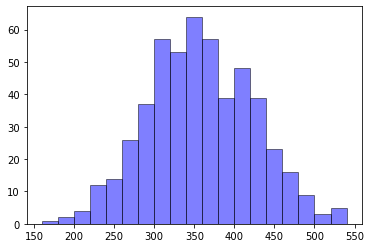

In [27]:
bin_edges = np.arange(160, 560, 20)
plt.hist(df.co_emissions, bins=bin_edges, density=False, histtype='bar', color='b', edgecolor='k', alpha=0.5)

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\seaborn\_core.py:1303: UserWarning: Vertical orientation ignored with only `x` specified.
  warnings.warn(single_var_warning.format("Vertical", "x"))


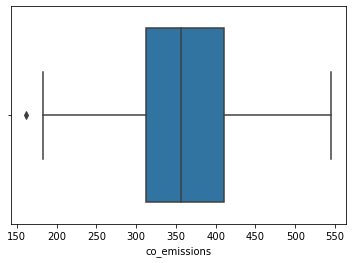

In [28]:
sns.boxplot(df['co_emissions'], orient='v')
plt.show()

### Factor1 - Fuel Type

In [29]:
# Factor1 - Fuel Type

df.fuel_type.value_counts()

Petrol    179
LPG       170
E85       161
Name: fuel_type, dtype: int64

In [30]:
df.groupby('fuel_type')['co_emissions'].mean()

fuel_type
E85       338.124534
LPG       363.744412
Petrol    371.722961
Name: co_emissions, dtype: float64

### Factor 2 - Manufacturer

In [31]:
df.manufacturer.value_counts()

Audi     142
Ford     132
Volvo    123
BMW      113
Name: manufacturer, dtype: int64

In [32]:
df.groupby('manufacturer')['co_emissions'].mean()

manufacturer
Audi     349.727254
BMW      377.538761
Ford     365.078561
Volvo    343.898293
Name: co_emissions, dtype: float64

## Problem 1: Is there any dependency on 'co_emissions' due to 'fuel_type'

In [33]:
# Null Hyp: Emissions from one fuel type == Other fuel type
# Ho = mu1 = mu2 = mu3
# Ha = alteast one carbon emission level is different from others

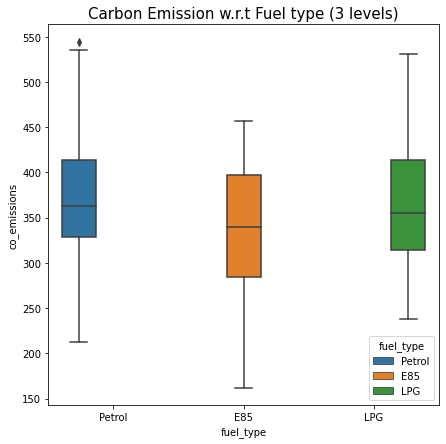

In [34]:
fig, ax = plt.subplots(figsize=(7,7))
a = sns.boxplot(x='fuel_type', y='co_emissions', data=df, hue='fuel_type')
a.set_title('Carbon Emission w.r.t Fuel type (3 levels)', fontsize=15)
plt.show()

In [35]:
# Assumption1: Normality
# For testing of normality, Shapiro-Wilks test is applied to the response

# Ho: Carbon emission follows a normal distribution
# Ha: Carbon emission does not follow a normal distribution

from scipy import stats

w, p_value = stats.shapiro(df['co_emissions'])
print('W value:', w, ' P Value ',p_value)

# P value is greater than 0.49 and we fail to reject null hyp
# We accept null hypothesis

W value: 0.9970714449882507  P Value  0.49723097681999207


In [44]:
# Assumption 2: Homogenity of Variance

print(df['co_emissions'][df.fuel_type == 'Petrol'])

statistic, p_value = stats.levene(
    df['co_emissions'][df.fuel_type == 'Petrol'],
    df['co_emissions'][df.fuel_type == 'E85'],
    df['co_emissions'][df.fuel_type == 'LPG'])
print('statistic: ', statistic, ' p_value: ', p_value)

# P value is large, we fail to reject null hypothesis

0      441.55
17     479.15
19     544.56
24     331.37
30     334.48
        ...  
501    487.88
503    420.66
505    348.62
506    348.42
507    330.01
Name: co_emissions, Length: 179, dtype: float64
statistic:  1.6432552897712633  p_value:  0.19437768490117


In [37]:
# Once 2 assumptions of One-Way ANOVA are statisfied, we can now compare population means
from statsmodels.formula.api import ols
from statsmodels.stats.anova import _get_covariance, anova_lm

formula = 'co_emissions ~ fuel_type'
mod = ols(formula, data=df).fit()
anovatbl = anova_lm(mod, type=1)
print(anovatbl)

              df        sum_sq       mean_sq          F    PR(>F)
fuel_type    2.0  1.028130e+05  51406.481215  11.976652  0.000008
Residual   507.0  2.176158e+06   4292.224647        NaN       NaN


C:\ProgramData\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0, 0.5, 'Residuals')

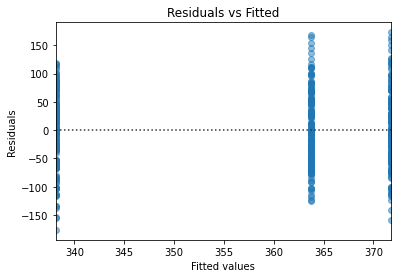

In [38]:
# model values
model_fitted_y = mod.fittedvalues

# model residuals
model_residuals = mod.resid

# normalized residuals
model_norm_residuals = mod.get_influence().resid_studentized_internal

# absolute squared normalized residuals
model_norm_residuals_abs_sqrt = np.sqrt(np.abs(model_norm_residuals))

# absolute residuals
model_abs_resid = np.abs(model_residuals)

# leverage, from statsmodels internals
model_leverage = mod.get_influence().hat_matrix_diag

# cook's distance, from statsmodels internals
model_cooks = mod.get_influence().cooks_distance[0]

plot_lm_1 = plt.figure()
plot_lm_1.axes[0] = sns.residplot(model_fitted_y, 'co_emissions', data=df, lowess=True, scatter_kws={'alpha': 0.5}, line_kws={'color': 'red', 'lw': 1, 'alpha': 0.8})
plot_lm_1.axes[0].set_title('Residuals vs Fitted')
plot_lm_1.axes[0].set_xlabel('Fitted values')
plot_lm_1.axes[0].set_ylabel('Residuals')

In [39]:
# apply oneway anova for manufacturer

formula = 'co_emissions ~ manufacturer'
mod = ols(formula, data=df).fit()
aov_tbl = anova_lm(mod, type=1)
print(aov_tbl)
# We reject the null hypothesis as the p value is smaller

                 df        sum_sq       mean_sq        F    PR(>F)
manufacturer    3.0  8.382457e+04  27941.524040  6.44076  0.000276
Residual      506.0  2.195146e+06   4338.233767      NaN       NaN


In [40]:
# Multiple mean comparison tests for Fuel Type
# Posthoc test: Tukey Test
from statsmodels.sandbox.stats.multicomp import MultiComparison

multicomp = MultiComparison(df.co_emissions, df.fuel_type)
print(multicomp.tukeyhsd().summary())

Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1 group2 meandiff p-adj   lower   upper  reject
----------------------------------------------------
   E85    LPG  25.6199 0.0012  8.6837  42.556   True
   E85 Petrol  33.5984  0.001 16.8707 50.3262   True
   LPG Petrol   7.9785 0.4931 -8.5144 24.4715  False
----------------------------------------------------


In [41]:
results = multicomp.tukeyhsd()
rdf = results.summary()
results_as_html = rdf.as_html()


In [42]:
multicomp = MultiComparison(df.co_emissions, df.manufacturer)
print(multicomp.tukeyhsd().summary())

 Multiple Comparison of Means - Tukey HSD, FWER=0.05  
group1 group2 meandiff p-adj   lower    upper   reject
------------------------------------------------------
  Audi    BMW  27.8115 0.0048   6.4089  49.2141   True
  Audi   Ford  15.3513 0.2178  -5.1756  35.8782  False
  Audi  Volvo   -5.829  0.882 -26.7415  15.0835  False
   BMW   Ford -12.4602 0.4541 -34.2191   9.2987  False
   BMW  Volvo -33.6405  0.001 -55.7635 -11.5175   True
  Ford  Volvo -21.1803 0.0516 -42.4573   0.0967  False
------------------------------------------------------


In [43]:
sns.__version__

'0.11.0'